In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
import statsmodels.formula.api as smf
from math import exp
from sklearn import linear_model, cross_validation
import scipy.stats as prr
import numpy as np
from IPython.display import display, HTML
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.formula.api as sm
import itertools

C:\Users\xtiangabe\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Regression Class

In [2]:
class Regression:
    def __init__(self, pathToData):
        self.data = pd.read_csv(pathToData, index_col=0)

    def getDataFrame(self):
        return self.data

    
    
    # get collinearity (r^2 value) of a pair of columns
    def getCollinearityScore(self, dependentCol, independentCol):
        array = self.data.values
        X = array[:, independentCol]
        Y = array[:, dependentCol]

        return prr.pearsonr(X, Y)
        # GET SUBTABLE CONTAINING ONLY THE INDEPENDENT COLUMN AND DEPENDENT COLUMN
        # df2 = self.data.iloc[:, [independentCol, dependentCol]]
        # CREATE FITTED MODEL USING ORDINARY LEAST SQUARES REGRESSION
        # lm = smf.ols(formula='Sales ~ TV', data=df2).fit()
        # RETURN RSQUARED VALUE FOR THE MODEL
        # return lm.rsquared

    # print collinearities (r^2 value) of each pair of columns
    def printAllCollinearities(self):
        array = self.data.values
        length_col = self.data.shape[1]
        while(0 != length_col-1):
            for x in range(0, length_col-1):
                X = array[:, x]
                Y = array[:, length_col-1]

                print("Collinearity between "+self.data.columns.values[x]+" & "+self.data.columns.values[length_col-1]+" = "+str(prr.pearsonr(X, Y)))
            length_col -= 1

    def getSubTable(self, col_names):
        array = self.data
        return array.loc[:, col_names]
            
    def getFittedRegressionModel(self, col_names, dependent_col_name):
        array = self.data
        X = array.loc[:, col_names]
        Y = array.loc[:, dependent_col_name]
        model = linear_model.LinearRegression()
        model.fit(X, Y)
        print("R^2 score: "+str(model.score(X, Y)))
        m = model.coef_
        b = model.intercept_
        # print("Intercept=" + str(b) + " Coefficient=" + str(m))
        return model

    def getBestFeaturesRCEV(self, col_names, dependent_col_name):
        array = self.data
        X = array.loc[:, col_names]
        Y = array.loc[:, dependent_col_name]
        feature_names = self.data.columns.values
        model = linear_model.LinearRegression()
        selector = RFECV(estimator=model, cv=10)
        selector.fit(X, Y)
        print(selector.ranking_)
        print("Optimal number of features3: " + str(selector.n_features_))
        print(sorted(zip(map(lambda x: round(x, 4), selector.ranking_), col_names)))
        print(selector.support_)
        
    def getXVals(self, col_names):
        #array = self.data
        array = self.data.copy()
        X = array.loc[:, col_names]
        return X
    
    def getYVals(self, col_names):
        #array = self.data
        array = self.data.copy()
        X = array.loc[:, col_names]
        return X
        
    def kFoldTest(self, col_names, dependent_col_name, test_row_num):
        #array = self.data
        array = self.data.copy()
        array = array.drop(array.index[test_row_num])
        
        X = array.loc[:, col_names]
        Y = array.loc[:, dependent_col_name]
        model = linear_model.LinearRegression()
        model.fit(X, Y)
        m = model.coef_
        b = model.intercept_
        return model
    
    def kFoldTest2(self, col_names, dependent_col_name, slice_size):
        #array = self.data
        array = self.data.copy()
        original = self.data.copy()
        iterations = len(array.index)/slice_size
        #print("ITERATIONS: "+str(iterations))
        if(len(array.index)%slice_size>0):
            iterations = int(iterations)+1
        iterations = int(iterations)
        for j in range(0, iterations):
            for i in range(0,len(array.index)):
                if (i/slice_size==j):
                    array = array.drop(array.index[i])

            X = array.loc[:, col_names]
            Y = array.loc[:, dependent_col_name]
            
            A = np.array(X.values)
            b = np.array(Y.values)
            res = lsq_linear(A, b, bounds=(0, 1000), lsmr_tol='auto', verbose=1);
            #print(res['x'])
            
            
            model = linear_model.LinearRegression()
            model.fit(X, Y)
            model.coef_ = res['x']
            model.intercept_ = 0
            m = model.coef_
            b = model.intercept_
            
            predicted_vals = []
            observed_vals = []
            array = self.data.copy()
            X = array.loc[:, col_names]
            Y = array.loc[:, dependent_col_name]
            size = 0
            for i in range(0,len(array.index)):
                #print(str(i)+" / "+str(slice_size)+" == "+str(j))
                if (int(i/slice_size)==j):
                    #print("WENT IN!")
                    size += 1
                    #print("length:"+str(len(X.index))+" index:"+str(i))
                    predicted_vals.append(model.predict(X.iloc[i , :].values.reshape(1,-1))[0])
                    #print(Y.iloc[i])
                    observed_vals.append(Y.iloc[i])
            rms1 = sqrt(mean_squared_error(observed_vals, predicted_vals))
            print("rms1:"+str(rms1)+" * "+str((100*slice_size)/sum(observed_vals)))
            rms2 = rms1*((100*slice_size)/sum(observed_vals))
            print("Trained using slice "+str(j)+": RawRMSE="+str(rms1)+" %RMSE="+str(rms2))  
            print("slice size: "+str(size))
            
    def statsmodelsRegressionSummary(self, col_names, dependent_col_name):
        array = self.data.copy()
        X = array.loc[:, col_names]
        Y = array.loc[:, dependent_col_name]
        result = sm.OLS( Y, X ).fit()
        return result

    def kFoldTest3(self, col_names, dependent_col_name, slice_size):
        total_rmse = 0
        #array = self.data
        array = self.data.copy()
        original = self.data.copy()
        iterations = len(array.index)/slice_size
        #print("ITERATIONS: "+str(iterations))
        if(len(array.index)%slice_size>0):
            iterations = int(iterations)+1
        iterations = int(iterations)
        for j in range(0, iterations):
            for i in range(0,len(array.index)):
                if (i/slice_size==j):
                    array = array.drop(array.index[i])

            X = array.loc[:, col_names]
            Y = array.loc[:, dependent_col_name]
            model = linear_model.LinearRegression()
            model.fit(X, Y)
            m = model.coef_
            b = model.intercept_
            
            predicted_vals = []
            observed_vals = []
            array = self.data.copy()
            X = array.loc[:, col_names]
            Y = array.loc[:, dependent_col_name]
            size = 0
            for i in range(0,len(array.index)):
                #print(str(i)+" / "+str(slice_size)+" == "+str(j))
                if (int(i/slice_size)==j):
                    #print("WENT IN!")
                    size += 1
                    #print("length:"+str(len(X.index))+" index:"+str(i))
                    predicted_vals.append(model.predict(X.iloc[i , :].values.reshape(1,-1))[0])
                    #print(Y.iloc[i])
                    observed_vals.append(Y.iloc[i])
            rms = sqrt(mean_squared_error(observed_vals, predicted_vals))
            rms = rms*((100*slice_size)/sum(observed_vals))
            total_rmse = total_rmse + rms
        return total_rmse


## Trip Generation Class

In [7]:
class TripGeneration:

    def __init__(self, pathToData, dependent_col_name):
        self.pathToData = pathToData
        self.dependent_col_name = dependent_col_name
        self.production_col_names = []
        self.production_constant = 0
        self.production_intercepts = []
        self.attraction_col_names = []
        self.attraction_constant = 0
        self.attraction_intercepts = []
        self.production_score = 0
        self.attraction_score = 0
        self.balancing_factor = 0
        
    def printAttributes(self):
        print("Attributes")
        print(self.production_col_names)
        print(self.production_constant)
        print(self.production_intercepts)
        print(self.attraction_col_names)
        print(self.attraction_constant)
        print(self.attraction_intercepts)

    def setProductionParameters(self, production_col_names, production_constant, production_intercepts):
        self.production_col_names = production_col_names
        self.production_constant = production_constant
        self.production_intercepts = production_intercepts
        
    def setAttractionParameters(self, attraction_col_names, attraction_constant, attraction_intercepts):
        self.attraction_col_names = attraction_col_names
        self.attraction_constant = attraction_constant
        self.attraction_intercepts = attraction_intercepts
        
    
    # get trip production score for 'zone'
    def getWholeTripProductionScore(self):
        data = pd.read_csv(self.pathToData, index_col=0)
        # implement specific way to get sub-table(data) just for specific 'zone' i.e: all rows related to zone1
        sub_table = data.loc[:, self.production_col_names]
        length_rows = sub_table.shape[0]
        for x in range(0, length_rows):
            row_values = sub_table.iloc[x, :].values
            self.production_score += self.production_constant
            for j in range(0,len(row_values)):
                self.production_score += int(row_values[j]*self.production_intercepts[j])
            #print("SELFPROD CURR: "+str(self.production_score))
        return int(self.production_score)

    # get trip attraction score for 'zone'
    def getWholeTripAttractionScore(self):
        data = pd.read_csv(self.pathToData, index_col=0)
        # implement specific way to get sub-table(data) just for specific 'zone' i.e: all rows related to zone1
        sub_table = data.loc[:, self.attraction_col_names]
        length_rows = sub_table.shape[0]
        for x in range(0, length_rows):
            row_values = sub_table.iloc[x, :].values
            self.attraction_score += self.attraction_constant
            for j in range(0,len(row_values)):
                self.attraction_score += int(row_values[j]*self.attraction_intercepts[j])
            #print("SELFATTR CURR: "+str(self.attraction_score))
        return int(self.attraction_score)
    
    def getZoneTripProductionScore(self, zone_number):
        self.production_score = 0
        data = pd.read_csv(self.pathToData, index_col=0)
        # implement specific way to get sub-table(data) just for specific 'zone' i.e: all rows related to zone1
        row_values = data.loc[zone_number, self.production_col_names].values
        
        self.production_score += self.production_constant
        for j in range(0,len(row_values)):
            self.production_score += row_values[j]*self.production_intercepts[j]

        return self.production_score
    
    def getZoneTripAttractionScore(self, zone_number):
        self.attraction_score = 0
        data = pd.read_csv(self.pathToData, index_col=0)
        # implement specific way to get sub-table(data) just for specific 'zone' i.e: all rows related to zone1
        row_values = data.loc[zone_number, self.production_col_names].values
        
        self.attraction_score += self.attraction_constant
        for j in range(0,len(row_values)):
            self.attraction_score += row_values[j]*self.attraction_intercepts[j]

        return self.attraction_score

    def doTripBalancing(self):
        self.balancing_factor = self.production_score/self.attraction_score
        self.attraction_score = self.balancing_factor * self.attraction_score
        self.production_score = self.balancing_factor * self.production_score
        # Implement trip balancing here VOID
        
    def getBalancingFactor(self):
        return self.balancing_factor
    
    def printAllZonalTripsProductionAttraction(self):
        productionScores = []
        attractionScores = []
        df = pd.DataFrame(columns=('Trip Production', 'Trip Atraction'))
        total_production = 0
        total_attraction = 0
        data = pd.read_csv(self.pathToData, index_col=0)
        length_rows = data.shape[0]
        for x in range(1, length_rows+1):
            attr_score = 0
            prod_score = 0
            attr_row_values = data.loc[x, self.attraction_col_names].values
            prod_row_values = data.loc[x, self.production_col_names].values
            attr_score += self.attraction_constant
            prod_score += self.production_constant
            for j in range(0,len(attr_row_values)):
                attr_score += attr_row_values[j]*self.attraction_intercepts[j]
            total_attraction += attr_score
            for j in range(0,len(prod_row_values)):
                prod_score += prod_row_values[j]*self.production_intercepts[j]
            total_production += prod_score
            df.loc[x] = [int(prod_score),int(attr_score)]
            productionScores.append(int(prod_score))
            attractionScores.append(int(attr_score))
            #print("Zone "+str(x)+": Production="+str(prod_score)+" , Attraction="+str(attr_score))
        return df, productionScores, attractionScores;
        #print("Total Production="+str(total_production)+" , Total Attraction="+str(total_attraction))
        
    def getTripProductionScores(self):
        productionScores = []
        total_production = 0
        total_attraction = 0
        data = pd.read_csv(self.pathToData, index_col=0)
        length_rows = data.shape[0]
        for x in range(1, length_rows+1):
            prod_score = 0
            prod_row_values = data.loc[x, self.production_col_names].values
            prod_score += self.production_constant
            for j in range(0,len(prod_row_values)):
                prod_score += prod_row_values[j]*self.production_intercepts[j]
            total_production += prod_score
            productionScores.append(prod_score)
        return productionScores
    
    def getProductionSubTable(self):
        data = pd.read_csv(self.pathToData, index_col=0)
        return data.loc[:, self.production_col_names]

        


# DATA
### Expected available parameters from the MMUTIS Update and Enhancement Project (MUCEP) Database

In [8]:
dummy_data = pd.read_csv('DummyDataRegression_revised.csv', index_col=0)
dummy_data.head()

,no_hh,avg_income,mem_no,no_mem_educwork,comm_area,park_area,indu_area,agri_area,resi_area,util_area,othe_area,trips
1,3779,18736.43821,12747,11894,75.838787,320.453730,50.304504,3.877656,753.816342,0.000000,0,20863
2,1349,18754.63306,4509,4238,76.584378,28.722817,120.806663,16.137527,1054.765270,4.793359,0,7389
3,1060,28070.75472,3624,3321,435.919028,20.733238,81.223612,4.631663,1403.462437,0.000000,0,6050
4,767,18507.17080,2598,2402,11.141258,1.514845,31.493130,121.179552,67.058721,0.000000,0,4305
5,862,21937.35499,2913,2720,60.375364,0.000000,31.602269,1.507656,137.409984,0.000000,0,4939


### Fused Zonal and Amenity data (OpenStreetMap)

In [9]:
dummy_data_amenities = pd.read_csv('DummyDataRegressionAmenitiex_revised.csv', index_col=0)
dummy_data_amenities.head()

,sust_amt,educ_amt,tran_amt,heal_amt,fina_amt,comm_amt,ente_amt,othe_amt,comm_area,park_area,indu_area,agri_area,resi_area,util_area,othe_area,trips
1,58,86,54,43,44,2,0,97,75.838787,320.453730,50.304504,3.877656,753.816342,0.000000,0,15611
2,214,41,43,65,104,1,7,68,76.584378,28.722817,120.806663,16.137527,1054.765270,4.793359,0,6412
3,1129,47,138,102,467,7,26,147,435.919028,20.733238,81.223612,4.631663,1403.462437,0.000000,0,7180
4,23,14,18,16,15,3,0,42,11.141258,1.514845,31.493130,121.179552,67.058721,0.000000,0,3890
5,184,14,36,42,78,3,4,44,60.375364,0.000000,31.602269,1.507656,137.409984,0.000000,0,5979


# DATA PREPARATION (Example Plan)

## Collinearity Checking using Peasrson Correlation (correlation coefficient, 2-tailed p-value)

In [10]:
data_filepath = "DummyDataRegression_revised.csv"
regression = Regression(data_filepath)
array = regression.getDataFrame().values
print("All collinearities:")
regression.printAllCollinearities()

All collinearities:
Collinearity between no_hh & trips = (0.88819908302512485, 1.9285699992241247e-06)
Collinearity between avg_income & trips = (-0.26124022358668669, 0.31115282884985307)
Collinearity between mem_no & trips = (0.86767932652407465, 6.4153591620644434e-06)
Collinearity between no_mem_educwork & trips = (0.87429475815909696, 4.4550812074522216e-06)
Collinearity between comm_area & trips = (0.64193276618452488, 0.0054670728832082183)
Collinearity between park_area & trips = (0.9103825506661708, 3.9232064579873457e-07)
Collinearity between indu_area & trips = (0.12611598135042928, 0.62958180030553945)
Collinearity between agri_area & trips = (0.66983263263870818, 0.0032642464610524533)
Collinearity between resi_area & trips = (0.70387236988126478, 0.0016136580187106745)
Collinearity between util_area & trips = (0.80628723468478913, 9.2652976729832789e-05)
Collinearity between othe_area & trips = (nan, 1.0)
Collinearity between no_hh & othe_area = (nan, 1.0)
Collinearity be

C:\Users\xtiangabe\Anaconda3\lib\site-packages\scipy\stats\stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\xtiangabe\Anaconda3\lib\site-packages\scipy\stats\stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


### Checking for Optimal Features using Recursive Feature Elimination with Cross-Validation

In [11]:
col_names = regression.getDataFrame().columns.values[0:11]
print(str(1))
dep_col_name = "trips"
print(str(2))
regression.getBestFeaturesRCEV(col_names, dep_col_name)
print(str(3))
col_names

1
2
[ 2 10  3  4  6  8  5  7  9  1 11]
Optimal number of features3: 1
[(1, 'util_area'), (2, 'no_hh'), (3, 'mem_no'), (4, 'no_mem_educwork'), (5, 'indu_area'), (6, 'comm_area'), (7, 'agri_area'), (8, 'park_area'), (9, 'resi_area'), (10, 'avg_income'), (11, 'othe_area')]
[False False False False False False False False False  True False]
3


array(['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork', 'comm_area',
       'park_area', 'indu_area', 'agri_area', 'resi_area', 'util_area',
       'othe_area'], dtype=object)

In [12]:
data_filepath2 = "DummyDataRegressionAmenitiex.csv"
regression2 = Regression(data_filepath2)
array2 = regression2.getDataFrame().values
print("All collinearities:")
regression2.printAllCollinearities()

All collinearities:
Collinearity between sust_amt & trips = (0.61766649945179353, 0.0082397277247921313)
Collinearity between educ_amt & trips = (0.79298891907477898, 0.00014625516874859079)
Collinearity between tran_amt & trips = (0.82659474668514443, 4.2998072277589239e-05)
Collinearity between heal_amt & trips = (0.7836582956773025, 0.00019770168871971209)
Collinearity between fina_amt & trips = (0.56994354452005569, 0.016913167026585154)
Collinearity between comm_amt & trips = (0.40246884564223007, 0.10924012866786645)
Collinearity between ente_amt & trips = (0.63964348181274389, 0.0056909899532994433)
Collinearity between othe_amt & trips = (0.81734620789132073, 6.1700600812943568e-05)
Collinearity between comm_area & trips = (0.70239128224202696, 0.0016671293361775938)
Collinearity between park_area & trips = (0.94004785612710895, 2.1005501466413752e-08)
Collinearity between indu_area & trips = (0.15090461252797308, 0.56317607573574535)
Collinearity between agri_area & trips = (0

C:\Users\xtiangabe\Anaconda3\lib\site-packages\scipy\stats\stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\xtiangabe\Anaconda3\lib\site-packages\scipy\stats\stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


In [13]:
col_names2 = regression2.getDataFrame().columns.values[1:15]
print(str(1))
dep_col_name2 = "trips"
print(str(2))
regression2.getBestFeaturesRCEV(col_names2, dep_col_name2)
print(str(3))
col_names2

1
2
[5 1 1 1 1 1 1 3 1 4 1 2 1 6]
Optimal number of features3: 9
[(1, 'agri_area'), (1, 'comm_amt'), (1, 'ente_amt'), (1, 'fina_amt'), (1, 'heal_amt'), (1, 'othe_amt'), (1, 'park_area'), (1, 'tran_amt'), (1, 'util_area'), (2, 'resi_area'), (3, 'comm_area'), (4, 'indu_area'), (5, 'educ_amt'), (6, 'othe_area')]
[False  True  True  True  True  True  True False  True False  True False
  True False]
3


array(['educ_amt', 'tran_amt', 'heal_amt', 'fina_amt', 'comm_amt',
       'ente_amt', 'othe_amt', 'comm_area', 'park_area', 'indu_area',
       'agri_area', 'resi_area', 'util_area', 'othe_area'], dtype=object)

In [10]:
 'util_area',
       'othe_area'
        
\n Correlation coeff=0.9125, P-value=3.31e-07'

IndentationError: unexpected indent (<ipython-input-10-1debb5dd00cc>, line 2)

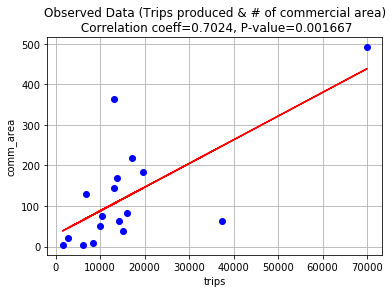

In [14]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["comm_area"], 'bo')
x = df["trips"]
y = df["comm_area"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('comm_area')
plt.title('Observed Data (Trips produced & # of commercial area)\n Correlation coeff=0.7024, P-value=0.001667')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

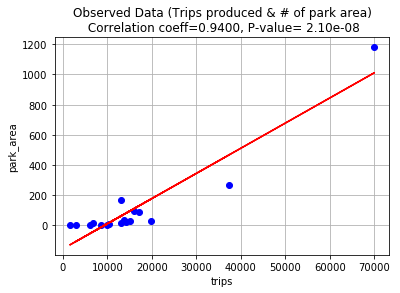

In [15]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["park_area"], 'bo')
x = df["trips"]
y = df["park_area"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('park_area')
plt.title('Observed Data (Trips produced & # of park area)\n Correlation coeff=0.9400, P-value= 2.10e-08')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

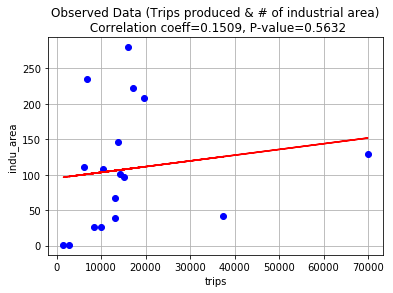

In [16]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["indu_area"], 'bo')
x = df["trips"]
y = df["indu_area"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('indu_area')
plt.title('Observed Data (Trips produced & # of industrial area)\n Correlation coeff=0.1509, P-value=0.5632')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

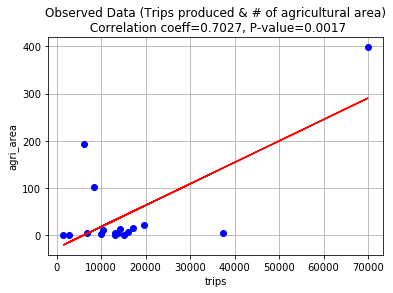

In [17]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["agri_area"], 'bo')
x = df["trips"]
y = df["agri_area"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('agri_area')
plt.title('Observed Data (Trips produced & # of agricultural area)\n Correlation coeff=0.7027, P-value=0.0017')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

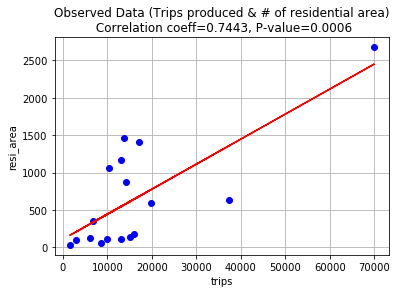

In [18]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["resi_area"], 'bo')
x = df["trips"]
y = df["resi_area"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('resi_area')
plt.title('Observed Data (Trips produced & # of residential area)\n Correlation coeff=0.7443, P-value=0.0006')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

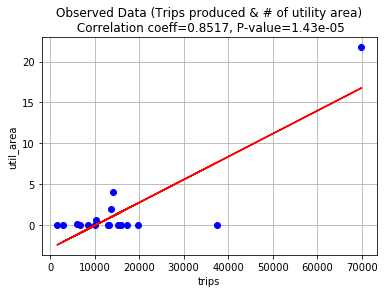

In [19]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["util_area"], 'bo')
x = df["trips"]
y = df["util_area"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('util_area')
plt.title('Observed Data (Trips produced & # of utility area)\n Correlation coeff=0.8517, P-value=1.43e-05')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

### Verify Collinearity through Scatter Plots

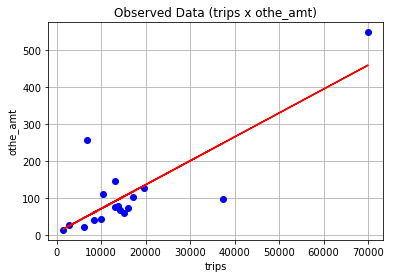

In [20]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["othe_amt"], 'bo')
x = df["trips"]
y = df["othe_amt"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('othe_amt')
plt.title('Observed Data (trips x othe_amt)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

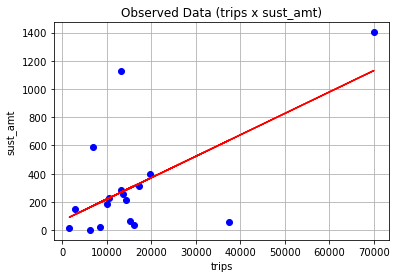

In [21]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["sust_amt"], 'bo')
x = df["trips"]
y = df["sust_amt"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('sust_amt')
plt.title('Observed Data (trips x sust_amt)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

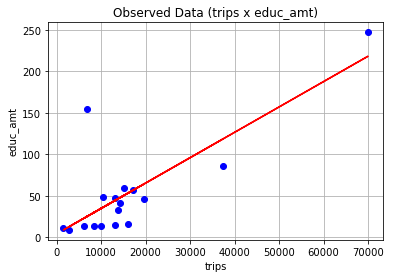

In [22]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["educ_amt"], 'bo')
x = df["trips"]
y = df["educ_amt"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('educ_amt')
plt.title('Observed Data (trips x educ_amt)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

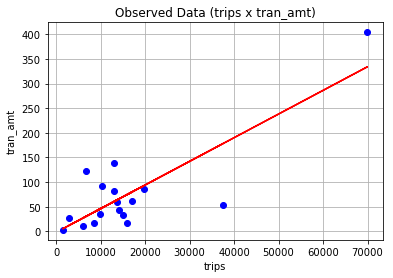

In [23]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["tran_amt"], 'bo')
x = df["trips"]
y = df["tran_amt"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('tran_amt')
plt.title('Observed Data (trips x tran_amt)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

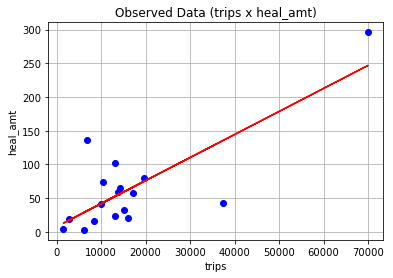

In [24]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["heal_amt"], 'bo')
x = df["trips"]
y = df["heal_amt"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('heal_amt')
plt.title('Observed Data (trips x heal_amt)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

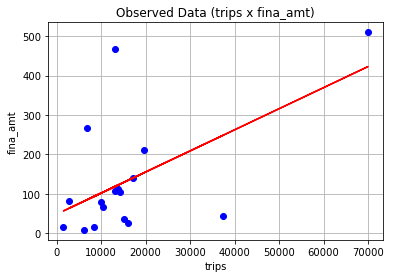

In [25]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["fina_amt"], 'bo')
x = df["trips"]
y = df["fina_amt"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('fina_amt')
plt.title('Observed Data (trips x fina_amt)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

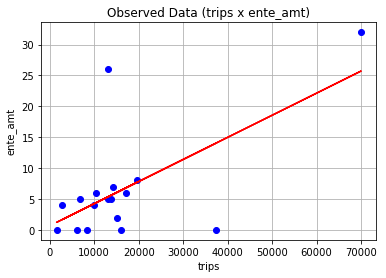

In [26]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["ente_amt"], 'bo')
x = df["trips"]
y = df["ente_amt"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('ente_amt')
plt.title('Observed Data (trips x ente_amt)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

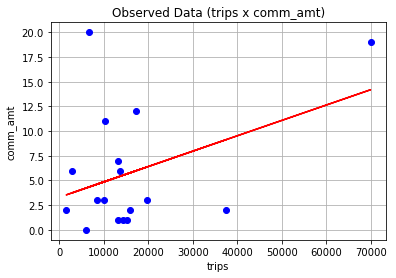

In [27]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["comm_amt"], 'bo')
x = df["trips"]
y = df["comm_amt"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('comm_amt')
plt.title('Observed Data (trips x comm_amt)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

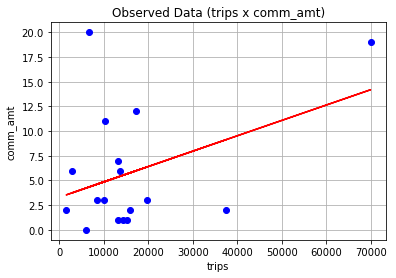

In [28]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["comm_amt"], 'bo')
x = df["trips"]
y = df["comm_amt"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('comm_amt')
plt.title('Observed Data (trips x comm_amt)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

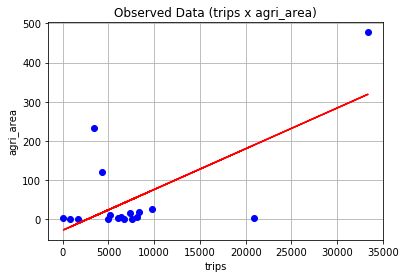

In [29]:
df = regression.getDataFrame()
plt.plot(df["trips"], df["agri_area"], 'bo')
x = df["trips"]
y = df["agri_area"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('agri_area')
plt.title('Observed Data (trips x agri_area)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

In [23]:
Collinearity between no_hh & trips = (0.92914760415527753, 7.1205170410730196e-08)
Collinearity between avg_income & trips = (0.91992035789848337, 1.7354578828442896e-07)
Collinearity between mem_no & trips = (0.91247798270778113, 3.305852610863916e-07)
Collinearity between no_mem_educwork & trips = (0.91764041951966036, 2.1277373172145904e-07)

SyntaxError: invalid syntax (<ipython-input-23-988561d38e77>, line 1)

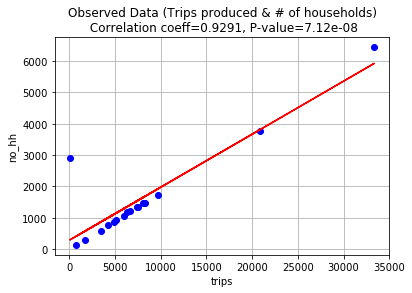

In [30]:
df = regression.getDataFrame()
plt.plot(df["trips"], df["no_hh"], 'bo')
x = df["trips"]
y = df["no_hh"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('no_hh')
plt.title('Observed Data (Trips produced & # of households)\n Correlation coeff=0.9291, P-value=7.12e-08')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

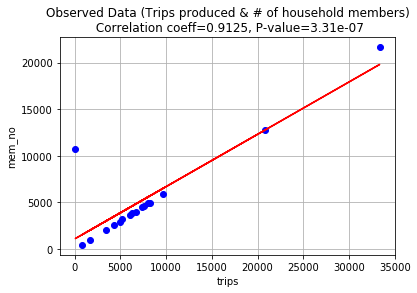

In [31]:
df = regression.getDataFrame()
plt.plot(df["trips"], df["mem_no"], 'bo')
x = df["trips"]
y = df["mem_no"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('mem_no')
plt.title('Observed Data (Trips produced & # of household members)\n Correlation coeff=0.9125, P-value=3.31e-07')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

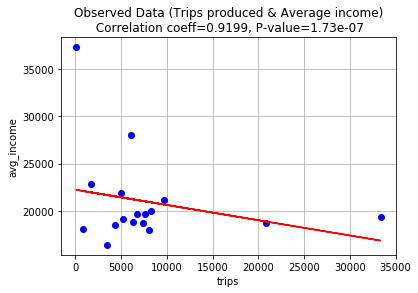

In [32]:
df = regression.getDataFrame()
plt.plot(df["trips"], df["avg_income"], 'bo')
x = df["trips"]
y = df["avg_income"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('avg_income')
plt.title('Observed Data (Trips produced & Average income)\n Correlation coeff=0.9199, P-value=1.73e-07')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

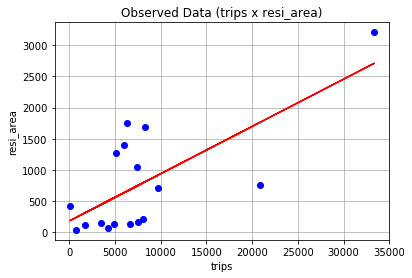

In [33]:
df = regression.getDataFrame()
plt.plot(df["trips"], df["resi_area"], 'bo')
x = df["trips"]
y = df["resi_area"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('resi_area')
plt.title('Observed Data (trips x resi_area)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

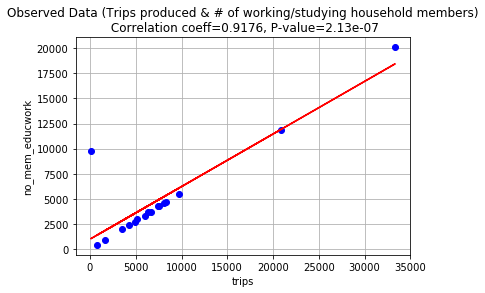

In [34]:
df = regression.getDataFrame()
plt.plot(df["trips"], df["no_mem_educwork"], 'bo')
x = df["trips"]
y = df["no_mem_educwork"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('no_mem_educwork')
plt.title('Observed Data (Trips produced & # of working/studying household members)\n Correlation coeff=0.9176, P-value=2.13e-07')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

In [29]:
df = regression.getDataFrame()
plt.plot(df["Trips"], df["Autos"], 'bo')
x = df["Trips"]
y = df["Autos"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('Trips')
plt.ylabel('Establishments')
plt.title('Observed Data (TRIPS x AUTOS)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

KeyError: 'Trips'

# Generate table that contains the aggregated information per zone, given the TAZ input file and the Households input file (income, houses, # amenities of each kind)

#### Create TripGenTableModel:
wherein its attributes are the columns in the table example (Out 348, remove trips column, shape coordinate, landuse).

#### Get number of TAZs
#### Get number of landuse per TAZ
#### Create [ ][ ] of TripGenTableModel

#### SAMPLE CODE
TripGenTableModel tgtm = [# of TAZs][ ]
for n in range(0,len(TAZ)):
    LUShapes lus = getImpactingShapes(TAZ[n]) #Returns the whole shape coors of impacting landuses together with its category
    for x in range(0, len(lus)):
        tgtm[n][x] = new TripGenTableModel()
        tgtm[n][x].setShapeCoordinate(TAZ[n], lus[x]) #sets a coor shape for the overlapping of the TAZ shape and landuse shape
        
for cbms_file in cmbs_files:
    for row in cbms_file:
        lat, long = getCoor(row)
        add_info_to_respective_TGTM(lat, long, row) #adds the info of the HH to the correct zone and landuse
        
        
        
        



# Detemine landuse of each zone using the land use file

# Get the corresponding trip productions and attractions per zone given the parameters

# MODEL FITTING

### Retreival of intercepts and coefficients
**Features for Trip production**: # of HH, # of HH members, # of employed, # of enrolled, Income, Landuse and Amenity Data

**Features for Trip attraction**: # of Establishments, # of working in area, # of enrolled in area, Landuse and Amenity Data

In [39]:
dep_col_name = "trips"
data_filepath = "DummyDataRegression.csv"
regression = Regression(data_filepath)

data_filepath2 = "DummyDataRegressionAmenitiex.csv"
regression2 = Regression(data_filepath2)

selected_feature_names = ["no_hh","avg_income","mem_no"]
selected_feature_names_attraction = ["sust_amt","educ_amt","tran_amt","heal_amt","fina_amt","comm_amt", "ente_amt","othe_amt",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
fitted_production_model_attr = regression2.getFittedRegressionModel(selected_feature_names_attraction, dep_col_name)

print("Prod Intercept:"+str(fitted_production_model.intercept_)+" Coef:"+str(fitted_production_model.coef_))
print("Attr Intercept:"+str(fitted_production_model_attr.intercept_)+" Coef:"+str(fitted_production_model_attr.coef_))

dummy_data = pd.read_csv('DummyDataRegressionHHTripsOnly.csv', index_col=0)
dummy_data.head()

R^2 score: 0.987350266174
R^2 score: 0.996911644387
Prod Intercept:344.745174492 Coef:[ 85.04687743   3.36621094 -26.75217765]
Attr Intercept:4805.98183877 Coef:[  -49.6028897     -4.83505864  -154.53369632   312.99534481    19.79017006
  -980.65529731  1164.01053445    58.86796291    13.15743504    81.67469428
   -14.09065401    10.80746015     6.22225556 -3549.39096573     0.        ]


,no_hh,avg_income,mem_no,no_mem_educwork,trips
1,3779,18736.43821,12747,11894,37428
2,1349,18754.63306,4509,4238,14213
3,1060,28070.75472,3624,3321,13730
4,767,18507.17080,2598,2402,8437
5,862,21937.35499,2913,2720,11306


In [31]:
print(selected_feature_names)
X_vals = regression.getXVals(selected_feature_names)
Y_vals = regression.getYVals(dep_col_name)

for x in range(len(X_vals.index)):
    Predicted_vals = []
    print("Test row: "+str(x))
    fitted_production_model2 = regression.kFoldTest(selected_feature_names, dep_col_name, x);
    #testdframe.head()
    #fitted_production_model2.predict(X_vals.iloc[x , :].values.reshape(1,-1))
    for z in range(len(X_vals.index)):
        #print("Actual Zone "+str(z)+": "+str(Y_vals.iloc[z]))
        #print("Predicted Zone "+str(z)+": "+str(fitted_production_model2.predict(X_vals.iloc[z , :].values.reshape(1,-1))[0]))
        Predicted_vals.append(fitted_production_model2.predict(X_vals.iloc[z , :].values.reshape(1,-1))[0])
    rms = sqrt(mean_squared_error(Y_vals.values, Predicted_vals))
    print("Trained using index "+str(x)+": RMS = "+str(rms))

['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork']
Test row: 0
Trained using index 0: RMS = 1642.8611353042031
Test row: 1
Trained using index 1: RMS = 1623.0075678854153
Test row: 2
Trained using index 2: RMS = 1613.9679788752348
Test row: 3
Trained using index 3: RMS = 1626.248724401083
Test row: 4
Trained using index 4: RMS = 1598.2276558902588
Test row: 5
Trained using index 5: RMS = 5983.535008027696
Test row: 6
Trained using index 6: RMS = 1604.1427427182311
Test row: 7
Trained using index 7: RMS = 1601.8320898685502
Test row: 8
Trained using index 8: RMS = 1641.223576273628
Test row: 9
Trained using index 9: RMS = 1614.0143609756592
Test row: 10
Trained using index 10: RMS = 1651.3620291500129
Test row: 11
Trained using index 11: RMS = 1615.7890835165513
Test row: 12
Trained using index 12: RMS = 1597.9605414533635
Test row: 13
Trained using index 13: RMS = 2396.378970999385
Test row: 14
Trained using index 14: RMS = 1598.4290560976747
Test row: 15
Trained using index 15: RMS 

In [32]:
rms = sqrt(mean_squared_error(Y_vals.values, Predicted_vals))
rms

1606.6848114811119

In [120]:
dep_col_name = "trips"
data_filepath = "DummyDataRegression.csv"
regression = Regression(data_filepath)

data_filepath2 = "DummyDataRegressionAmenitiex.csv"
regression2 = Regression(data_filepath2)

selected_feature_names = ["mem_no"]
selected_feature_names_attraction = ["sust_amt","educ_amt","tran_amt","heal_amt","fina_amt","comm_amt", "ente_amt","othe_amt",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
fitted_production_model_attr = regression2.getFittedRegressionModel(selected_feature_names_attraction, dep_col_name)

print("Prod Intercept:"+str(fitted_production_model.intercept_)+" Coef:"+str(fitted_production_model.coef_))
print("Attr Intercept:"+str(fitted_production_model_attr.intercept_)+" Coef:"+str(fitted_production_model_attr.coef_))

dummy_data = pd.read_csv('DummyDataRegression.csv', index_col=0)
dummy_data.head()

R^2 score: 0.832616068926
R^2 score: 0.996911644387
Prod Intercept:645.860276196 Coef:[ 2.81864012]
Attr Intercept:4805.98183877 Coef:[  -49.6028897     -4.83505864  -154.53369632   312.99534481    19.79017006
  -980.65529731  1164.01053445    58.86796291    13.15743504    81.67469428
   -14.09065401    10.80746015     6.22225556 -3549.39096573     0.        ]


,no_hh,avg_income,mem_no,no_mem_educwork,comm_area,park_area,indu_area,agri_area,resi_area,util_area,othe_area,trips
1,3779,17110,12747,11894,63.27,267.37,41.97,3.23,628.96,0.00,0,37428
2,1349,6272,4509,4238,63.89,23.96,100.79,13.46,880.06,3.99,0,14213
3,1060,5670,3624,3321,363.71,17.29,67.77,3.86,1171.00,0.00,0,13093
4,767,3390,2598,2402,9.29,1.26,26.27,101.10,55.95,0.00,0,8437
5,862,4271,2913,2720,50.37,0.00,26.36,1.25,114.65,0.00,0,9969


In [24]:
print(selected_feature_names)
X_vals = regression.getXVals(selected_feature_names)
Y_vals = regression.getYVals(dep_col_name)

for x in range(len(X_vals.index)):
    Predicted_vals = []
    print("Test row: "+str(x))
    fitted_production_model2 = regression.kFoldTest(selected_feature_names, dep_col_name, x);
    #testdframe.head()
    #fitted_production_model2.predict(X_vals.iloc[x , :].values.reshape(1,-1))
    for z in range(len(X_vals.index)):
        #print("Actual Zone "+str(z)+": "+str(Y_vals.iloc[z]))
        #print("Predicted Zone "+str(z)+": "+str(fitted_production_model2.predict(X_vals.iloc[z , :].values.reshape(1,-1))[0]))
        Predicted_vals.append(fitted_production_model2.predict(X_vals.iloc[z , :].values.reshape(1,-1))[0])
    rms = sqrt(mean_squared_error(Y_vals.values, Predicted_vals))
    print("Trained using index "+str(x)+": RMS = "+str(rms))

['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork', 'comm_area', 'park_area', 'indu_area', 'agri_area', 'resi_area', 'util_area', 'othe_area']
Test row: 0
Trained using index 0: RMS = 1513.8400745835781
Test row: 1
Trained using index 1: RMS = 1750.189584314592
Test row: 2
Trained using index 2: RMS = 1156.465665211328
Test row: 3
Trained using index 3: RMS = 1206.031396848907
Test row: 4
Trained using index 4: RMS = 1161.20530774799
Test row: 5
Trained using index 5: RMS = 6472.118807400362
Test row: 6
Trained using index 6: RMS = 1260.61796218028
Test row: 7
Trained using index 7: RMS = 1173.0711517046389
Test row: 8
Trained using index 8: RMS = 1736.3256089725148
Test row: 9
Trained using index 9: RMS = 1258.9239107597048
Test row: 10
Trained using index 10: RMS = 1349.430196341538
Test row: 11
Trained using index 11: RMS = 1313.8326517895605
Test row: 12
Trained using index 12: RMS = 1179.1122567101238
Test row: 13
Trained using index 13: RMS = 11791.146640090681
Test row: 14
Trai

In [25]:
print(selected_feature_names)
X_vals = regression.getXVals(selected_feature_names)
Y_vals = regression.getYVals(dep_col_name)
Predicted_vals = []
for x in range(len(X_vals.index)):
    
    print("Test row: "+str(x))
    fitted_production_model2 = regression.kFoldTest(selected_feature_names, dep_col_name, x);
    #testdframe.head()
    #fitted_production_model2.predict(X_vals.iloc[x , :].values.reshape(1,-1))
    #fitted
    print("Actual Zone "+str(x)+": "+str(Y_vals.iloc[x]))
    print("Predicted Zone "+str(x)+": "+str(fitted_production_model2.predict(X_vals.iloc[x , :].values.reshape(1,-1))[0]))
    Predicted_vals.append(fitted_production_model2.predict(X_vals.iloc[x , :].values.reshape(1,-1))[0])

['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork', 'comm_area', 'park_area', 'indu_area', 'agri_area', 'resi_area', 'util_area', 'othe_area']
Test row: 0
Actual Zone 0: 37428
Predicted Zone 0: 41583.8900525
Test row: 1
Actual Zone 1: 14213
Predicted Zone 1: 20711.7925161
Test row: 2
Actual Zone 2: 13093
Predicted Zone 2: 12798.5943355
Test row: 3
Actual Zone 3: 8437
Predicted Zone 3: 6403.17213939
Test row: 4
Actual Zone 4: 9969
Predicted Zone 4: 9057.55220162
Test row: 5
Actual Zone 5: 6779
Predicted Zone 5: 33417.09022
Test row: 6
Actual Zone 6: 10373
Predicted Zone 6: 7287.32105234
Test row: 7
Actual Zone 7: 13713
Predicted Zone 7: 14781.5778026
Test row: 8
Actual Zone 8: 6084
Predicted Zone 8: 12138.1679747
Test row: 9
Actual Zone 9: 17149
Predicted Zone 9: 19700.7350103
Test row: 10
Actual Zone 10: 13107
Predicted Zone 10: 17188.0208826
Test row: 11
Actual Zone 11: 19694
Predicted Zone 11: 16024.5765148
Test row: 12
Actual Zone 12: 1542
Predicted Zone 12: 2929.74082313
Test row:

In [26]:
rms = sqrt(mean_squared_error(Y_vals.values, Predicted_vals))
rms

13789.642839207072

In [27]:
fitted_production_model2, testdframe = regression.kFoldTest(selected_feature_names, dep_col_name, 1)
X_vals = regression.getXVals(selected_feature_names)
testdframe.head()
fitted_production_model2.predict(X_vals.loc[1 , :])

TypeError: 'LinearRegression' object is not iterable

### Prediction of Trip Production & Attraction using the intercepts and coefficients

In [ ]:
trip_gen = TripGeneration("DummyDataRegressionFused.csv", "trips")
prod_col_names = selected_feature_names
attr_col_names = selected_feature_names_attraction
trip_gen.setProductionParameters(prod_col_names, fitted_production_model.intercept_, fitted_production_model.coef_)
trip_gen.setAttractionParameters(attr_col_names, fitted_production_model_attr.intercept_, fitted_production_model_attr.coef_)
print("Example:")
print("Overall Trip Production: "+str(trip_gen.getWholeTripProductionScore()))
print("Overall Trip Attraction: "+str(trip_gen.getWholeTripAttractionScore()))

### Computing for Trip Balancing Factor

In [ ]:
trip_gen.doTripBalancing()
print("Balancing Factor: "+str(trip_gen.getBalancingFactor()))


### Zonal-level Trip Production & Attraction Scores

In [ ]:
zonal_df, productions, attractions = trip_gen.printAllZonalTripsProductionAttraction()
display(zonal_df)

# Model Validation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
X_digits = regression.getSubTable(selected_feature_names)
Y_digits = regression.getSubTable(dep_col_name)
scores = cross_validation.cross_val_score(fitted_production_model, X_digits, Y_digits, scoring='r2', cv=10,)
#X_digits.shape, Y_digits.shape
scores

# MODEL OUTPUT

# Trip Distribution Class

In [ ]:
class TripDistribution:

    def __init__(self, productions, attractions):
        self.productions = productions
        self.attractions = attractions
        self.row = len(productions)
        self.col = len(attractions)
        self.possibleError = 3
        self.error = 0

    def getGeneralizedCost(self, cost):
        return 1.0 / (cost * cost)

    def getTripDistribution(self):
        distributions = [[self.attractions[y] for x in range(self.row)] for y in range(self.col)]
        costMatrix = [[1 for x in range(self.row)] for y in range(self.col)]
        #costMatrix = [[1.0, 1.2, 1.8], [1.2, 1.0, 1.5], [1.8, 1.5, 1.0]]
        A = [1 for x in range(self.row)]
        B = [1 for x in range(self.col)]

        currentBalancingFactor = 0  # 0 for A, 1 for B
        isConvergent = False

        while isConvergent == False:
            if currentBalancingFactor == 0:
                A = self.computeA(B, costMatrix)
                currentBalancingFactor = 1
            elif currentBalancingFactor == 1:
                B = self.computeB(A, costMatrix)
                currentBalancingFactor = 0
            distributions = self.computeDistributions(A, B, costMatrix)
            isConvergent = self.checkIfConvergent(distributions)
        return distributions

    def computeDistributions(self, A, B, costMatrix):
        distributions = [[self.attractions[y] for x in range(self.row)] for y in range(self.col)]
        for x in range(self.row):
            for y in range(self.col):
                distributions[x][y] = A[x] * self.productions[x] * B[y] * self.attractions[y] * self.getGeneralizedCost(costMatrix[x][y])
        return distributions

    def checkIfConvergent(self, distributions):
        error = self.getError(distributions)
        if error <= self.possibleError:
            self.error = error
            return True
        return False

    def getError(self, distributions):
        error = 0
        derivedProductions = [0 for x in range(self.row)]
        derivedAttractions = [0 for x in range(self.col)]

        for x in range(self.row):
            for y in range(self.col):
                derivedProductions[x] += distributions[x][y]
                derivedAttractions[y] += distributions[x][y]

        for x in range(self.row):
            error += abs(derivedProductions[x] - self.productions[x])
            error += abs(derivedAttractions[y] - self.attractions[y])

        return error

    def computeA(self, B, costMatrix):
        A = [1 for x in range(self.row)]
        for x in range(0, self.row):
            sum = 0.0
            for y in range(0, self.col):
                sum += B[y] * self.attractions[y] * self.getGeneralizedCost(costMatrix[x][y])
            A[x] = 1.0 / sum
        return A

    def computeB(self, A, costMatrix):
        B = [1 for x in range(self.col)]
        for x in range(0, self.row):
            sum = 0.0
            for y in range(0, self.col):
                sum += A[y] * self.productions[y] * self.getGeneralizedCost(costMatrix[x][y])
            B[x] = 1.0 / sum
        return B

# Data

## The result from trip generation (trip production and attraction) will be passed to trip distribution

In [ ]:
td = TripDistribution(productions, attractions)

#pandas_distrib = pd.DataFrame(td, columns=('1','2'))

#print("Productions: " + str(productions))
#print("Attractions: " + str(attractions))

In [ ]:
distribution = td.getTripDistribution()

pandas_distrib = pd.DataFrame(distribution, columns=range(0,len(productions)))

# pandas_distrib.head()
display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in distribution)
        )
))

# Error

In [ ]:
print("Error: " + str(td.error))

# Modal Split Class

In [ ]:
import random
class ModalSplit:

    def __init__(self, od_matrix, pathToData):
        self.od_matrix = od_matrix
        self.pathToData = pathToData
        self.travel_costs = []
        self.travel_probabilities = []
        self.modes = ['jeep','bus','train']
        
    def computeGeneralizedCosts(self, zone_number):
        #data = pd.read_csv(self.pathToData, index_col=0)
        self.travel_costs = [None] * len(self.modes)
        for x in range(0, len(self.modes)):
            self.travel_costs[x] = random.randrange(1,4)
            
        #Compute for generalized cost for each mode for this specific zone
        # populate self.travel_costs with the travel costs
        self.computeModalProbabilities()
        
    def computeModalProbabilities(self):
        self.travel_probabilities = [None] * len(self.modes)
        sum = 0
        #print(len(self.travel_costs))
        for x in range(0,3):
            sum += exp(-self.travel_costs[x])
        for x in range(0,3):
            self.travel_probabilities[x] = exp(-self.travel_costs[x])/sum
        #print(self.travel_costs)
        #print(self.travel_probabilities)
    
    def getPartitionedTripsByMode(self, total_trips):
        return total_trips*self.travel_probabilities[0], self.travel_probabilities[1], self.travel_probabilities[2]
    
    def process_od_matrix(self):
        #print("size:"+str(len(self.od_matrix))+","+str(len(self.od_matrix[0])))
        #df = DataFrame(columns=('lib', 'qty1', 'qty2'))
        #for i in range(5):
            #df.loc[i] = [randint(-1,1) for n in range(3)]
        cols = list(range(len(self.od_matrix[0])))
        df_list = []
        for x in range(0, len(self.modes)):
            df = pd.DataFrame(columns=cols) 
            df_list.append(df)
            
        for y in range(0, len(self.od_matrix)):
            self.computeGeneralizedCosts(y)
            for z in range(0, len(self.modes)):
                od_row = []
                for x in range(0, len(self.od_matrix[0])):
                    #print("x:"+str(x)+" y:"+str(y)+" z:"+str(z))
                    od_row.append(round(self.od_matrix[x][y]*self.travel_probabilities[z],2))
                df_list[z].loc[y] = od_row
                
        return df_list
                

In [ ]:
modal_split = ModalSplit(distribution,"datapath")
list_of_dataframes_by_mode = modal_split.process_od_matrix()

## Mode 1

In [ ]:
display(list_of_dataframes_by_mode[0])

## Mode 2

In [ ]:
display(list_of_dataframes_by_mode[1])

## Mode 3

In [ ]:
display(list_of_dataframes_by_mode[2])

## FOR TRIP GENERATION EXPERIMENTS
Use this section to test trip tripgeneration

In [35]:
selected_feature_names = ["no_hh","avg_income","mem_no","no_mem_educwork",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
dep_col_name = "trips"
data_filepath = "DummyDataRegression_revised.csv"
array = pd.read_csv(data_filepath, index_col=0)
X = array.loc[:, selected_feature_names]
Y = array.loc[:, dep_col_name]


selected_feature_names2 = ["sust_amt","educ_amt","tran_amt","heal_amt","fina_amt","comm_amt", "ente_amt","othe_amt",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
dep_col_name2 = "trips"
data_filepath2 = "DummyDataRegressionAmenitiex_revised.csv"
array2 = pd.read_csv(data_filepath2, index_col=0)
X2 = array2.loc[:, selected_feature_names2]
Y2 = array2.loc[:, dep_col_name2]

fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
fitted_production_model_attr = regression2.getFittedRegressionModel(selected_feature_names2, dep_col_name2)

#print("Prod Intercept:"+str(fitted_production_model.intercept_)+" Coef:"+str(fitted_production_model.coef_))
#print("Attr Intercept:"+str(fitted_production_model_attr.intercept_)+" Coef:"+str(fitted_production_model_attr.coef_))
#print(fitted_production_model.coef_)


R^2 score: 0.99170614505
R^2 score: 0.996911644387


In [36]:
from scipy.sparse import rand
from scipy.optimize import lsq_linear
import sys

A = np.array(X.values)
b = np.array(Y.values)
res = lsq_linear(A, b, bounds=(0, 1000), lsmr_tol='auto', verbose=1)
print(res['x'])
#[ 85.04687743   3.36621094 -26.75217765]

The relative change of the cost function is less than `tol`.
Number of iterations 20, initial cost 2.8864e+12, final cost 8.3017e+07, first-order optimality 1.59e-07.
[  3.04156366e+00   1.38767539e-02   8.81298622e-18   2.75093984e-17
   4.88221301e-23   7.44158845e+00   8.59505052e-18   2.18538435e-21
   1.44405803e+00   1.23602105e-16   1.00000000e-01]


In [37]:
from scipy.sparse import rand
from scipy.optimize import lsq_linear
import sys

A = np.array(X2.values)
b = np.array(Y2.values)
res2 = lsq_linear(A, b, bounds=(0, 1000), lsmr_tol='auto', verbose=1)
print(res2['x'])
#[ 85.04687743   3.36621094 -26.75217765]

The relative change of the cost function is less than `tol`.
Number of iterations 14, initial cost 3.0053e+10, final cost 5.3578e+07, first-order optimality 1.56e-05.
[  7.19248083e-22   3.06103118e+01   1.22181039e-20   1.18773210e-19
   7.85821582e-24   1.34278010e-24   2.84369185e-22   1.11817815e-22
   4.84500091e+00   1.44005060e+01   1.37141692e+01   3.23873059e-01
   1.09169247e+00   3.22354125e-24   1.00000000e-01]


## Trip Production Experiment:
Change the values after "fitted_production_model.predict(["

In [13]:
#x4 x1.16
#3.37 0.74
#fitted_production_model.predict([73444,252283.04,294170,189034,3.74E-05,3.06E-05,9.67E-05,0,0.000137578,0,0])[0]
#36088
#print(fitted_production_model.intercept_)
#fitted_production_model.coef_= res['x']
fitted_production_model.coef_ = res['x']
fitted_production_model.intercept_ = 0
#print(fitted_production_model.coef_)
fitted_production_model.predict([ 
 
 
73444,
21023.5866,
294170,
189034,
    3.74E-05,
    3.06E-05,9.67E-05,0,0.000137578,0,0




])[0]

C:\Users\xtiangabe\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


434868.3672945298

## Trip Attraction Experiment:
Change the values after "fitted_production_model_attr.predict(["

In [25]:
#x4 x1.16
#3.37 0.74
#fitted_production_model.predict([73444,252283.04,294170,189034,3.74E-05,3.06E-05,9.67E-05,0,0.000137578,0,0])[0]
#36088
fitted_production_model_attr.coef_ = res2['x']
#print(res2['x'])
fitted_production_model_attr.intercept_ = 0
fitted_production_model_attr.predict([ 
58,86,54,43,44,2,0,97,6.33E-05,0.000267378,4.20E-05,3.24E-06,0.000628963,0,0


])[0]

C:\Users\xtiangabe\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


2564.3663311868436

## Additional regression info:

In [38]:
dep_col_name = "trips"
data_filepath = "DummyDataRegression_revised.csv"
regression = Regression(data_filepath)

data_filepath2 = "DummyDataRegressionAmenitiex_revised.csv"
regression2 = Regression(data_filepath2)

selected_feature_names = ["no_hh","mem_no","no_mem_educwork"]
selected_feature_names_attraction = ["sust_amt","educ_amt","tran_amt","heal_amt","fina_amt","comm_amt", "ente_amt","othe_amt",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
result = regression.statsmodelsRegressionSummary(selected_feature_names, dep_col_name)
result.summary()

C:\Users\xtiangabe\Anaconda3\lib\site-packages\scipy\stats\stats.py:1327: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  trips   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     495.4
Date:                Wed, 05 Jul 2017   Prob (F-statistic):           1.93e-14
Time:                        21:57:23   Log-Likelihood:                -142.74
No. Observations:                  17   AIC:                             291.5
Df Residuals:                      14   BIC:                             294.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
no_hh              33.5216     10.812      3.101      0.008      10.333      56.710
mem_no            -29.8981      7.124     -4.197      0.001     -45.178     -14.618
no_mem_educwork    23.1163     10.705      2.159      0.049       0.155      46.077
==============================================================================
Omnibus:                        0.686   Durbin-Watson:                   2.604
Prob(Omnibus):                  0.710   Jarque-Bera (JB):                0.661
Skew:                           0.391   Prob(JB):                        0.719
Kurtosis:                       2.433   Cond. No.                         594.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## K-fold validation (6-fold) and measuring by % RMSE values

In [83]:
totalrmse = 0
print(selected_feature_names)
X_vals = regression.getXVals(selected_feature_names)
Y_vals = regression.getYVals(dep_col_name)
regression.kFoldTest2(selected_feature_names, dep_col_name, 3)


['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork', 'comm_area', 'park_area', 'indu_area', 'agri_area', 'resi_area', 'util_area', 'othe_area']
The relative change of the cost function is less than `tol`.
Number of iterations 19, initial cost 3.4193e+12, final cost 1.2915e+08, first-order optimality 3.83e-07.
rms1:9398.854228678712 * 0.00463434980072
Trained using slice 0: RawRMSE=9398.854228678712 %RMSE=43.5575782217
slice size: 3
The relative change of the cost function is less than `tol`.
Number of iterations 24, initial cost 5.0990e+12, final cost 1.6692e+08, first-order optimality 1.21e-07.
rms1:8537.622966295372 * 0.011911852293
Trained using slice 1: RawRMSE=8537.622966295372 %RMSE=101.698903708
slice size: 3
The relative change of the cost function is less than `tol`.
Number of iterations 20, initial cost 5.6892e+12, final cost 1.7184e+08, first-order optimality 2.22e-05.
rms1:1077.9049385311462 * 0.00994365263507
Trained using slice 2: RawRMSE=1077.9049385311462 %RMSE=10.71831

In [19]:
#x4 x1.16
#3.37 0.74
#fitted_production_model.predict([73444,252283.04,294170,189034,3.74E-05,3.06E-05,9.67E-05,0,0.000137578,0,0])[0]
#36088
#print(fitted_production_model.intercept_)
#fitted_production_model.coef_= res['x']
fitted_production_model.coef_ = res['x']
fitted_production_model.intercept_ = 0
print(fitted_production_model.coef_)
fitted_production_model.predict([ 
 
3779,
17110,
12747,
11894,
63.27,
267.37,
41.97,
3.23,
628.96,
0,
0

])[0]

[  5.90456940e+000   5.77052508e-002   1.37222509e-033   4.94065646e-324
   5.79718102e-026   1.94474899e+001   8.64172470e-029   1.70091033e-025
   3.71466566e+000   1.04524070e-029   1.00000000e-001]


C:\Users\xtiangabe\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


30836.756076565678

In [25]:
#x4 x1.16
#3.37 0.74
#fitted_production_model.predict([73444,252283.04,294170,189034,3.74E-05,3.06E-05,9.67E-05,0,0.000137578,0,0])[0]
#36088
fitted_production_model_attr.coef_ = res2['x']
print(res2['x'])
fitted_production_model_attr.intercept_ = 0
fitted_production_model_attr.predict([ 
 58,
86,
54,
43,
44,
2,
20,
97,
63.27,
267.37,
41.97,
3.23,
628.96,
0,
0

])[0]

[  2.23501746e-16   2.98180289e+01   7.26239182e-16   1.43687118e-15
   1.16790905e-17   2.80332165e-19   1.37219337e-19   8.98948053e-17
   5.98251085e-01   4.15707106e+01   3.83165553e+01   6.38897234e-21
   4.90685694e+00   6.17212673e-23   1.00000000e-01]


C:\Users\xtiangabe\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


18411.325285029558

## K-fold validation (17-fold)

In [82]:
regression.kFoldTest2(selected_feature_names, dep_col_name, 1);

The relative change of the cost function is less than `tol`.
Number of iterations 19, initial cost 3.4193e+12, final cost 1.2915e+08, first-order optimality 3.83e-07.
rms1:15860.527952685807 * 0.00267179651598
Trained using slice 0: RawRMSE=15860.527952685807 %RMSE=42.3761033255
slice size: 1
The relative change of the cost function is less than `tol`.
Number of iterations 27, initial cost 7.8273e+12, final cost 1.7096e+08, first-order optimality 4.44e-03.
rms1:1439.986447313906 * 0.00703581228453
Trained using slice 1: RawRMSE=1439.986447313906 %RMSE=10.1314743356
slice size: 1
The relative change of the cost function is less than `tol`.
Number of iterations 23, initial cost 3.1603e+12, final cost 1.7127e+08, first-order optimality 8.88e-05.
rms1:1231.4532126301074 * 0.00763766898343
Trained using slice 2: RawRMSE=1231.4532126301074 %RMSE=9.40543200665
slice size: 1
The relative change of the cost function is less than `tol`.
Number of iterations 24, initial cost 5.0990e+12, final cos

### 2.) with LANDUSE variables

In [ ]:
dummy_data = pd.read_csv('DummyDataRegression.csv', index_col=0)
dummy_data.head()

In [ ]:
regression.kFoldTest2(["no_hh","avg_income","mem_no","no_mem_educwork"], dep_col_name, 1)

In [ ]:
regression.kFoldTest2(['no_hh', 'avg_income', 'mem_no', 'agri_area', 'resi_area', 'util_area'], dep_col_name, 1)

In [ ]:

        
dep_col_name = "trips"
data_filepath = "DummyDataRegression.csv"
regression = Regression(data_filepath)
original_df  =  pd.read_csv(data_filepath, index_col=0)
data_filepath2 = "DummyDataRegressionAmenitiex.csv"
regression2 = Regression(data_filepath2)

selected_feature_names_attraction = ["sust_amt","educ_amt","tran_amt","heal_amt","fina_amt","comm_amt", "ente_amt","othe_amt",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
#fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
#fitted_production_model_attr = regression2.getFittedRegressionModel(selected_feature_names_attraction, dep_col_name)
##

selected_feature_names = ["no_hh","avg_income","mem_no","no_mem_educwork"]
landuse_names = ["comm_area","park_area", "indu_area","agri_area",
                         "resi_area", "util_area"]
totalrmse = 0
print(selected_feature_names)
X_vals = regression.getXVals(selected_feature_names+landuse_names)
Y_vals = regression.getYVals(dep_col_name)
best_comb = []
best_score = 0
initialized = False

for L in range(1, len(selected_feature_names+landuse_names)+1):
  for subset in itertools.combinations(selected_feature_names+landuse_names, L):
    curr_cols = list(subset)
    print("current: "+str(curr_cols))
    totalrmse = 0
    rms = regression.kFoldTest3(curr_cols, dep_col_name, 3)
    totalrmse += rms
    #print("Trained using index "+str(x)+": RMSE = "+str(rms))
    print("TOTAL RMSE: "+str(totalrmse))
    if(initialized == False):
        best_score = totalrmse
        initialized = True 
        best_comb = curr_cols
    else:
        if(totalrmse < best_score):
            best_score = totalrmse
            best_comb = curr_cols
print("\n \nBest Score: "+str(best_score))
print("Best Combination: "+str(best_comb))      
        

In [26]:
dep_col_name = "trips"
data_filepath = "DummyDataRegression.csv"
regression = Regression(data_filepath)
original_df  =  pd.read_csv(data_filepath, index_col=0)
data_filepath2 = "DummyDataRegressionAmenitiex.csv"
regression2 = Regression(data_filepath2)

selected_feature_names_attraction = ["sust_amt","educ_amt","tran_amt","heal_amt","fina_amt","comm_amt", "ente_amt","othe_amt",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
#fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
#fitted_production_model_attr = regression2.getFittedRegressionModel(selected_feature_names_attraction, dep_col_name)
##

selected_feature_names = ["no_hh","avg_income","mem_no","no_mem_educwork"]
landuse_names = ["comm_area","park_area", "indu_area","agri_area",
                         "resi_area", "util_area"]
totalrmse = 0
print(selected_feature_names)
X_vals = regression.getXVals(selected_feature_names+landuse_names)
Y_vals = regression.getYVals(dep_col_name)
best_comb = []
best_score = 0
initialized = False

for L in range(1, len(selected_feature_names+landuse_names)+1):
  for subset in itertools.combinations(selected_feature_names+landuse_names, L):
    curr_cols = list(subset)
    print("current: "+str(curr_cols))
    totalrmse = 0
    for x in range(len(X_vals.index)):
        Predicted_vals = []
        #print("Test row: "+str(x))
        fitted_production_model2 = regression.kFoldTest(curr_cols, dep_col_name, x);
        #testdframe.head()
        #fitted_production_model2.predict(X_vals.iloc[x , :].values.reshape(1,-1))
        for z in range(len(X_vals.index)):
            #print("Actual Zone "+str(z)+": "+str(Y_vals.iloc[z]))
            #print("Predicted Zone "+str(z)+": "+str(fitted_production_model2.predict(X_vals.iloc[z , :].values.reshape(1,-1))[0]))
            #print("subset"+str(list(subset)))
            Predicted_vals.append(fitted_production_model2.predict(X_vals.iloc[z , :].loc[curr_cols].values.reshape(1,-1))[0])
        rms = sqrt(mean_squared_error(Y_vals.values, Predicted_vals))
        rms = rms*((100)/sum(Predicted_vals))
        totalrmse += rms
        #print("Trained using index "+str(x)+": RMSE = "+str(rms))
    print("TOTAL RMSE: "+str(totalrmse))
    if(initialized == False):
        best_score = totalrmse
        initialized = True 
        best_comb = curr_cols
    else:
        if(totalrmse < best_score):
            best_score = totalrmse
            best_comb = curr_cols
print("\n \nBest Score: "+str(best_score))
print("Best Combination: "+str(best_comb)) 



['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork']
current: ['no_hh']
TOTAL RMSE: 36.2228552615
current: ['avg_income']
TOTAL RMSE: 95.1221104612
current: ['mem_no']
TOTAL RMSE: 40.1719419942
current: ['no_mem_educwork']
TOTAL RMSE: 38.999776254
current: ['comm_area']
TOTAL RMSE: 70.3617498867
current: ['park_area']
TOTAL RMSE: 34.5821077079
current: ['indu_area']
TOTAL RMSE: 95.3271958003
current: ['agri_area']
TOTAL RMSE: 73.446540179
current: ['resi_area']
TOTAL RMSE: 65.8815832609
current: ['util_area']
TOTAL RMSE: 53.9174901731
current: ['no_hh', 'avg_income']
TOTAL RMSE: 22.6910997796
current: ['no_hh', 'mem_no']
TOTAL RMSE: 13.4882343458
current: ['no_hh', 'no_mem_educwork']
TOTAL RMSE: 14.9726303869
current: ['no_hh', 'comm_area']
TOTAL RMSE: 34.3878182543
current: ['no_hh', 'park_area']
TOTAL RMSE: 27.7020226485
current: ['no_hh', 'indu_area']
TOTAL RMSE: 34.9581155703
current: ['no_hh', 'agri_area']
TOTAL RMSE: 34.2733683201
current: ['no_hh', 'resi_area']


KeyboardInterrupt: 

## TRIP GENERATION TESTING #6:
Examine the effect of increasing/decreasing the number of each of the types of landuse per zone, and verify its effect to the number of trips produced and attracted per zone

## Base/Original data 

In [ ]:
dep_col_name = "trips"
data_filepath = "DummyDataRegression.csv"
regression = Regression(data_filepath)

selected_feature_names = ["no_hh","avg_income","mem_no","no_mem_educwork","comm_area","park_area", "indu_area","agri_area",
                         "resi_area", "util_area","othe_area"]
fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)

dummy_data = pd.read_csv('DummyDataRegression.csv', index_col=0)
dummy_data.head()

## Case 1:
Using the 1st row of the original data (zone 1), increase the number of residential areas, and check its effect to the resulting trips produced.

In [ ]:
data_filepath2 = "DummyDataRegressionEXP6.csv"
regression2 = Regression(data_filepath2)
dummy_data = pd.read_csv(data_filepath2, index_col=0)
dummy_data.head()

## Case 1 Result:
The predicted number of trips produced from zone 1, given the original number of residential areas.

In [ ]:
X_vals = regression.getXVals(selected_feature_names)
fitted_production_model.predict(X_vals.iloc[0 , :].values.reshape(1,-1))[0]

The predicted number of trips produced from zone 1, given that the number of residential areas were increased.

In [ ]:
X_vals = regression2.getXVals(selected_feature_names)
fitted_production_model.predict(X_vals.iloc[0 , :].values.reshape(1,-1))[0]

# Scatter plots for the zonal trips produced of other studies

## 1.) HHIS from MUCEP

In [43]:
dep_col_name = "trips"
selected_feature_names = ["no_hh","avg_income","mem_no","no_mem_educwork","comm_area", 
                          "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
data_filepath = "DummyDataRegression_revised.csv"
regression = Regression(data_filepath)
X_vals = regression.getXVals(selected_feature_names)
Y_vals = regression.getYVals(dep_col_name)

fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)

from scipy.sparse import rand
from scipy.optimize import lsq_linear
import sys

A = np.array(X_vals.values)
b = np.array(Y_vals.values)
res = lsq_linear(A, b, bounds=(0, 1000), lsmr_tol='auto', verbose=1)

predictions = []
predictions2 = []
for x in range(0,list(X_vals.values.shape)[0]):
    predictions.append(fitted_production_model.predict(X_vals.iloc[x , :].values.reshape(1,-1))[0])
fitted_production_model.coef_ = res['x']
fitted_production_model.intercept_ = 0
for x in range(0,list(X_vals.values.shape)[0]):
    predictions2.append(fitted_production_model.predict(X_vals.iloc[x , :].values.reshape(1,-1))[0])
print(predictions)
print(predictions2)
#print (ret['x'].T)
#output:
#[ 2.50e-07  6.93e-01]

R^2 score: 0.99170614505
The relative change of the cost function is less than `tol`.
Number of iterations 20, initial cost 2.8864e+12, final cost 8.3017e+07, first-order optimality 1.59e-07.
[20775.899376246118, 8246.0126828577304, 5790.0968753636644, 3705.6580185484577, 5006.0196449572986, 613.69733384046776, 3989.4907638937511, 6977.5930588402753, 4225.3730333967851, 8950.7844890683482, 7899.8864239089271, 8432.2997284426001, 1000.235397293618, 33157.259006779823, 769.61664594949252, 8032.2310723784831, 7151.8464482345571]
[15227.309339872902, 6100.2084482055025, 5794.5578563966847, 2697.8083185759056, 3124.6751451460436, 10134.875696519412, 4999.9795858261768, 6737.4735184308429, 2239.0918170256896, 8001.7221149331363, 5659.4531035168311, 6841.8305696903772, 726.10785926783683, 35005.59642426452, 1397.9807356076949, 5920.2323923479807, 4892.4494752041401]


['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork']


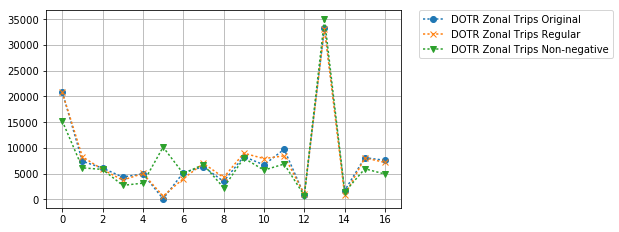

In [44]:
dep_col_name = "trips"
data_filepath = "DummyDataRegression_revised.csv"
regression = Regression(data_filepath)
original_df  =  pd.read_csv(data_filepath, index_col=0)

#fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
#fitted_production_model_attr = regression2.getFittedRegressionModel(selected_feature_names_attraction, dep_col_name)
##

selected_feature_names = ["no_hh","avg_income","mem_no","no_mem_educwork"]
landuse_names = ["comm_area","park_area", "indu_area","agri_area",
                         "resi_area", "util_area"]
totalrmse = 0
print(selected_feature_names)
X_vals = regression.getXVals(selected_feature_names+landuse_names)
Y_vals = regression.getYVals(dep_col_name)
best_comb = []
best_score = 0
initialized = False

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(221)
ax1.grid()
#hhisSum = sum(Y_vals.values)
mark1 = ax1.plot(range(0, 17), Y_vals.values, label="DOTR Zonal Trips Original", ls="dotted", marker="o")
mark1 = ax1.plot(range(0, 17), predictions, label="DOTR Zonal Trips Regular", ls="dotted", marker="x")
mark1 = ax1.plot(range(0, 17), predictions2, label="DOTR Zonal Trips Non-negative", ls="dotted", marker="v")
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## 2.) A study based on MUCEP

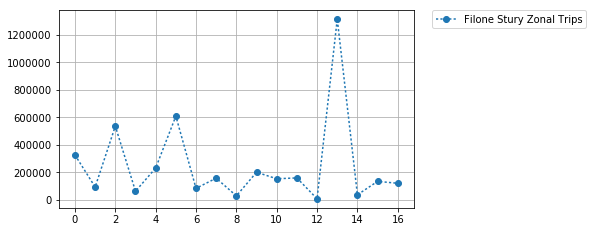

In [46]:
FILONE_MUCEP_TRIP_PROD = [326411,93639,535638,63112,231470,608551,84204,157800,29288,200924,153585
                        ,159682,7882,1313553,37197,134726,120622]
filoneSum = sum(FILONE_MUCEP_TRIP_PROD)
#ratio = hhisSum/filoneSum
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(221)
ax1.grid()
mark1 = ax1.plot(range(0, 17), FILONE_MUCEP_TRIP_PROD, label="Filone Stury Zonal Trips", ls="dotted", marker="o")
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


In [ ]:
FILONE_MUCEP_TRIP_PROD = [326411,93639,535638,63112,231470,608551,84204,157800,29288,200924,153585
                        ,159682,7882,1313553,37197,134726,120622]
filoneSum = sum(FILONE_MUCEP_TRIP_PROD)
ratio = hhisSum/filoneSum
FILONE_MUCEP_TRIP_PROD = [x * ratio for x in FILONE_MUCEP_TRIP_PROD]
print(str(sum(FILONE_MUCEP_TRIP_PROD)) + " " + str(hhisSum))
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(221)
ax1.grid()
mark1 = ax1.plot(range(0, 17), FILONE_MUCEP_TRIP_PROD, label="Filone Stury Zonal Trips", ls="dotted", marker="o")
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
difference = myFormattedList = [ round(elem, 1) for elem in (FILONE_MUCEP_TRIP_PROD - Y_vals.values)]
print(Y_vals.values)
print(FILONE_MUCEP_TRIP_PROD)
print([ round(elem, 1) for elem in FILONE_MUCEP_TRIP_PROD - Y_vals.values ])


# SCRATCH CELLS:

In [ ]:
dep_col_name = "trips"
data_filepath = "DummyDataRegression.csv"
regression = Regression(data_filepath)

data_filepath2 = "DummyDataRegressionAmenitiex.csv"
regression2 = Regression(data_filepath2)

selected_feature_names = ["no_hh","avg_income","mem_no","no_mem_educwork","comm_area","park_area", "indu_area","agri_area",
                         "resi_area", "util_area","othe_area"]
selected_feature_names_attraction = ["sust_amt","educ_amt","tran_amt","heal_amt","fina_amt","comm_amt", "ente_amt","othe_amt",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
fitted_production_model_attr = regression2.getFittedRegressionModel(selected_feature_names_attraction, dep_col_name)

print("Prod Intercept:"+str(fitted_production_model.intercept_)+" Coef:"+str(fitted_production_model.coef_))
print("Attr Intercept:"+str(fitted_production_model_attr.intercept_)+" Coef:"+str(fitted_production_model_attr.coef_))

dummy_data = pd.read_csv('DummyDataRegression.csv', index_col=0)
dummy_data.head()

In [ ]:
totalrmse = 0
print(selected_feature_names)
X_vals = regression.getXVals(selected_feature_names)
Y_vals = regression.getYVals(dep_col_name)

for x in range(len(X_vals.index)):
    Predicted_vals = []
    print("Test row: "+str(x))
    fitted_production_model2 = regression.kFoldTest(selected_feature_names, dep_col_name, x);
    #testdframe.head()
    #fitted_production_model2.predict(X_vals.iloc[x , :].values.reshape(1,-1))
    for z in range(len(X_vals.index)):
        #print("Actual Zone "+str(z)+": "+str(Y_vals.iloc[z]))
        #print("Predicted Zone "+str(z)+": "+str(fitted_production_model2.predict(X_vals.iloc[z , :].values.reshape(1,-1))[0]))
        Predicted_vals.append(fitted_production_model2.predict(X_vals.iloc[z , :].values.reshape(1,-1))[0])
    rms = sqrt(mean_squared_error(Y_vals.values, Predicted_vals))
    totalrmse += rms
    print("Trained using index "+str(x)+": RMSE = "+str(rms))
print("TOTAL RMSE: "+str(totalrmse))

In [ ]:
dep_col_name = "trips"
data_filepath = "DummyDataRegression.csv"
regression = Regression(data_filepath)

data_filepath2 = "DummyDataRegressionAmenitiex.csv"
regression2 = Regression(data_filepath2)

selected_feature_names = ["no_hh","avg_income","mem_no","no_mem_educwork","comm_area","park_area", "indu_area","agri_area",
                         "resi_area", "util_area","othe_area"]
selected_feature_names_attraction = ["sust_amt","educ_amt","tran_amt","heal_amt","fina_amt","comm_amt", "ente_amt","othe_amt",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
fitted_production_model_attr = regression2.getFittedRegressionModel(selected_feature_names_attraction, dep_col_name)

#print("Prod Intercept:"+str(fitted_production_model.intercept_)+" Coef:"+str(fitted_production_model.coef_))
#print("Attr Intercept:"+str(fitted_production_model_attr.intercept_)+" Coef:"+str(fitted_production_model_attr.coef_))

dummy_data = pd.read_csv('DummyDataRegression.csv', index_col=0)
dummy_data.head()